<a href="https://colab.research.google.com/github/nilakanta123/ShortTermLoadForecasting/blob/main/Parallel_2DCNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import metrics
import math
from statistics import stdev, mean
import time

import tensorflow as tf
from tensorflow.keras import layers, models, Model, utils

#import io
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.7 MB/s eta 0:00:00


In [3]:
from pyts.image import GramianAngularField

In [4]:
path = "/content/drive/MyDrive/SELECTED_DATASETS/malaysia_all_data_for_paper.csv"
df = pd.read_csv(path,parse_dates=['time'],index_col=['time'])
df.columns

Index(['temperature', 'load'], dtype='object')

In [5]:
def reframe(load_serie, temp_serie, lookback, horizon):
    X1 = []
    X2 = []
    y = []
    n = len(load_serie)-lookback-horizon+1
    for i in range(n):
        X1.append(load_serie[i:i+lookback])
        X2.append(temp_serie[i:i+lookback]) 
        y.append(load_serie[i+lookback:i+lookback+horizon])
    return np.array(X1),np.array(X2),np.array(y)

def reframe2(series, target_column, lookback, horizon):
    X = []
    y = []
    n = len(series)-lookback-horizon+1
    for i in range(n):
        X.append(series[i:i+lookback])  
        y.append(series[target_column][i+lookback:i+lookback+horizon])
    return np.array(X), np.array(y)

HORIZON=1
BATCH_SIZE = 32
EPOCHS = 20

steps = lambda x : int(math.ceil(1.*x/BATCH_SIZE))

def plot_history(history):
  plt.figure(figsize=(15,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()
    
import random
def plot_prediction(actual, pred, npoints=50):
  if npoints == 0:
    p1=actual.flatten()
    p2=pred.flatten()
  else:
    p1=actual.flatten()[0:npoints]
    p2=pred.flatten()[0:npoints]
  plt.figure(figsize=(15,5))
  plt.plot(p1, label='Actual Load', marker='o', zorder=-10)
  plt.plot(p2, label='Predicted Load', marker='X',zorder=-10)
  plt.title(f'Pridiction of next %d hours' % npoints)
  plt.ylabel('Load')
  plt.xlabel('Hours')
  plt.legend()
  plt.show()

def plot_img(train_X):
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(train_X[2], interpolation='nearest') #'none', 'antialiased', 'nearest', 
  #'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 
  #'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.
  plt.show()


window size 12


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12251, 12, 1) (12251, 12, 12, 1) (12251, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2616, 12, 1) (2616, 12, 12, 1) (2616, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2616, 12, 1) (2616, 12, 12, 1) (2616, 1)
LOAD INPUTS  (None, 12, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 12, 12, 1)
CONVO BLOCK  (None, 8, 8, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
383/383 [==============================] - 7s 10ms/step - loss: 0.0164 - val_loss: 0.0069
Epoch 2/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 3/50
383/383 [==============================] - 4s 11ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 4/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 5/50
383/383 [==============================] - 3s 8ms

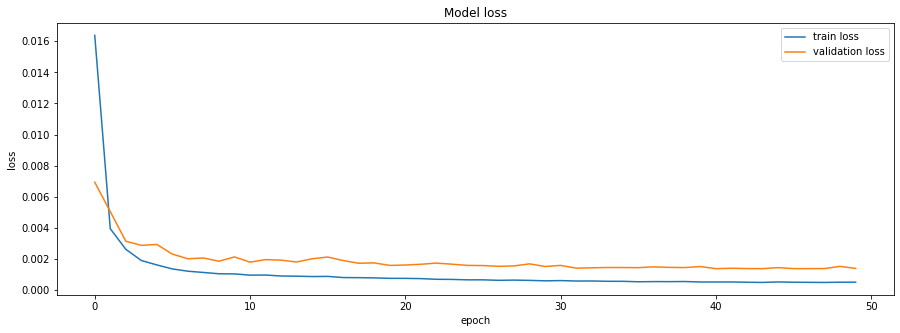

In [ ]:
#@title
LOOKBACK=12
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

Window size = 24


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12239, 24, 1) (12239, 24, 24, 1) (12239, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2604, 24, 1) (2604, 24, 24, 1) (2604, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2604, 24, 1) (2604, 24, 24, 1) (2604, 1)
LOAD INPUTS  (None, 24, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 24, 24, 1)
CONVO BLOCK  (None, 20, 20, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
383/383 [==============================] - 4s 7ms/step - loss: 0.0129 - val_loss: 0.0050
Epoch 2/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 3/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 4/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 5/50
383/383 [==============================] - 2s 5ms

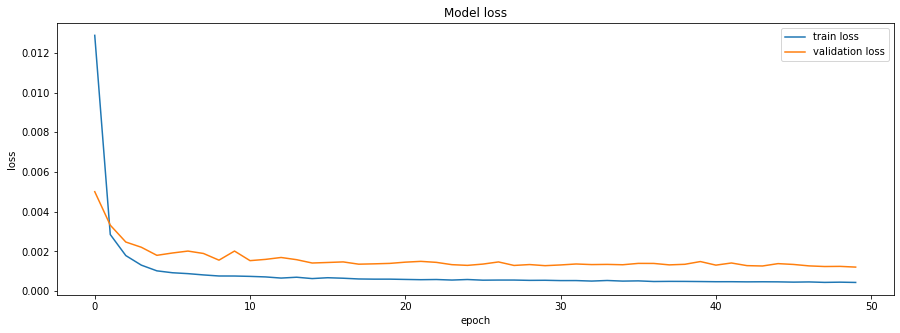

In [ ]:
#@title
LOOKBACK=24
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

window size 36


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12227, 36, 1) (12227, 36, 36, 1) (12227, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2592, 36, 1) (2592, 36, 36, 1) (2592, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2592, 36, 1) (2592, 36, 36, 1) (2592, 1)
LOAD INPUTS  (None, 36, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 36, 36, 1)
CONVO BLOCK  (None, 32, 32, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
383/383 [==============================] - 6s 8ms/step - loss: 0.2432 - val_loss: 0.0127
Epoch 2/50
383/383 [==============================] - 3s 9ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 3/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 4/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/50
383/383 [==============================] - 2s 6ms

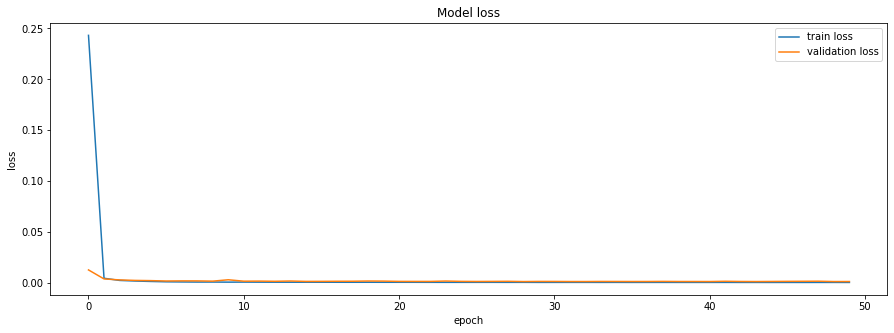

In [ ]:
#@title
LOOKBACK=36
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

window size = 48


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12215, 48, 1) (12215, 48, 48, 1) (12215, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2580, 48, 1) (2580, 48, 48, 1) (2580, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2580, 48, 1) (2580, 48, 48, 1) (2580, 1)
LOAD INPUTS  (None, 48, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 48, 48, 1)
CONVO BLOCK  (None, 44, 44, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
382/382 [==============================] - 8s 13ms/step - loss: 0.0144 - val_loss: 0.0059
Epoch 2/50
382/382 [==============================] - 5s 14ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 3/50
382/382 [==============================] - 4s 11ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 4/50
382/382 [==============================] - 4s 10ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/50
382/382 [==============================] - 5s

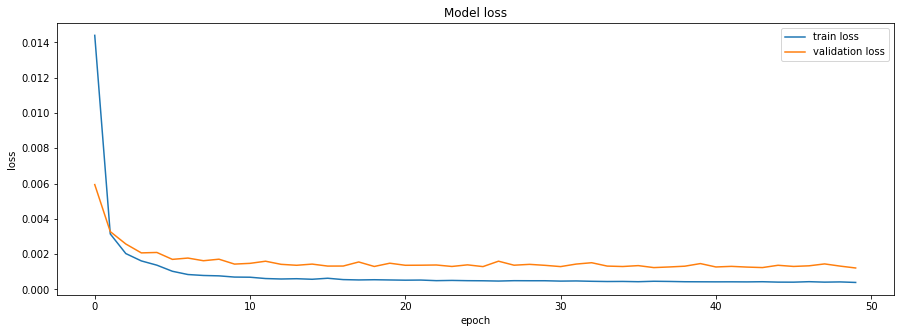

In [ ]:
#@title
LOOKBACK=48
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

window size = 60


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12203, 60, 1) (12203, 60, 60, 1) (12203, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2568, 60, 1) (2568, 60, 60, 1) (2568, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2568, 60, 1) (2568, 60, 60, 1) (2568, 1)
LOAD INPUTS  (None, 60, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 60, 60, 1)
CONVO BLOCK  (None, 56, 56, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
382/382 [==============================] - 18s 14ms/step - loss: 0.0156 - val_loss: 0.0047
Epoch 2/50
382/382 [==============================] - 5s 14ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 3/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 4/50
382/382 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 5/50
382/382 [==============================] - 3s 

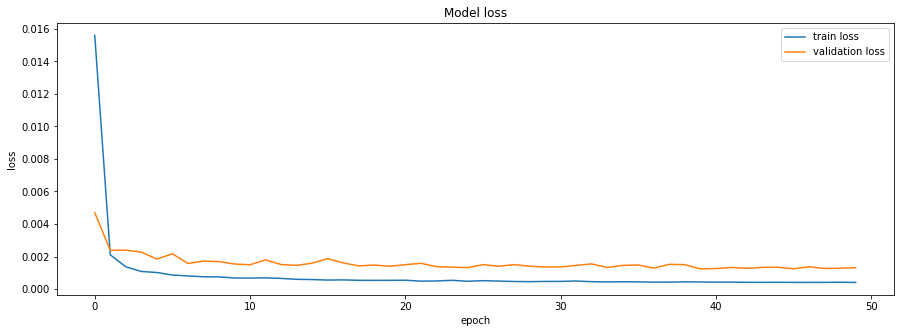

In [ ]:
LOOKBACK=60
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

Window size = 72


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12191, 72, 1) (12191, 72, 72, 1) (12191, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2556, 72, 1) (2556, 72, 72, 1) (2556, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2556, 72, 1) (2556, 72, 72, 1) (2556, 1)
LOAD INPUTS  (None, 72, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 72, 72, 1)
CONVO BLOCK  (None, 68, 68, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 6s 12ms/step - loss: 0.0131 - val_loss: 0.0058
Epoch 2/50
381/381 [==============================] - 3s 8ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 3/50
381/381 [==============================] - 3s 8ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 4/50
381/381 [==============================] - 3s 8ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 5/50
381/381 [==============================] - 4s 10

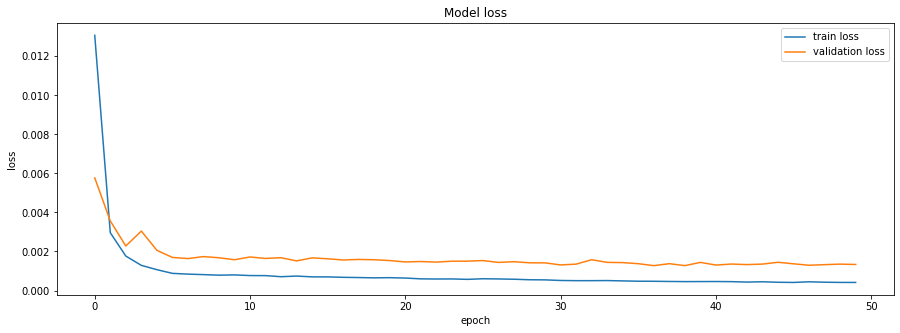

In [ ]:
#@title
LOOKBACK=72
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

WINDOWS SIZE = 84


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12179, 84, 1) (12179, 84, 84, 1) (12179, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2544, 84, 1) (2544, 84, 84, 1) (2544, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2544, 84, 1) (2544, 84, 84, 1) (2544, 1)
LOAD INPUTS  (None, 84, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 84, 84, 1)
CONVO BLOCK  (None, 80, 80, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 6s 11ms/step - loss: 0.0157 - val_loss: 0.0046
Epoch 2/50
381/381 [==============================] - 3s 9ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 3/50
381/381 [==============================] - 4s 11ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/50
381/381 [==============================] - 4s 11ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 5/50
381/381 [==============================] - 5s 

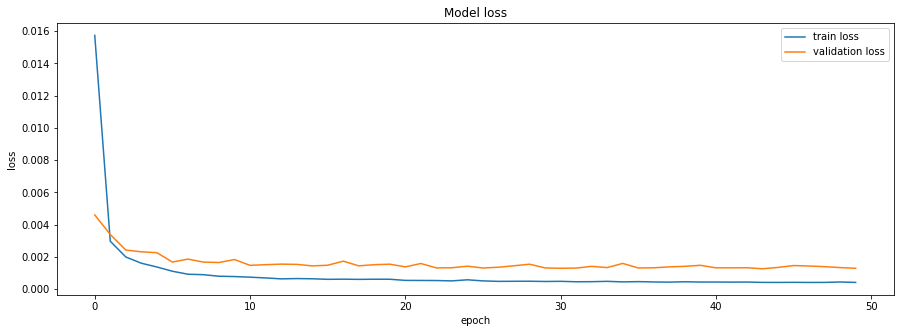

In [ ]:
#@title
LOOKBACK=84
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",model.name)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

WINDOWS SIZE = 96


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12167, 96, 1) (12167, 96, 96, 1) (12167, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2532, 96, 1) (2532, 96, 96, 1) (2532, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2532, 96, 1) (2532, 96, 96, 1) (2532, 1)
LOAD INPUTS  (None, 96, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 96, 96, 1)
CONVO BLOCK  (None, 92, 92, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 7s 15ms/step - loss: 0.0144 - val_loss: 0.0054
Epoch 2/50
381/381 [==============================] - 5s 12ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 3/50
381/381 [==============================] - 5s 13ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 4/50
381/381 [==============================] - 5s 12ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 5/50
381/381 [==============================] - 4s

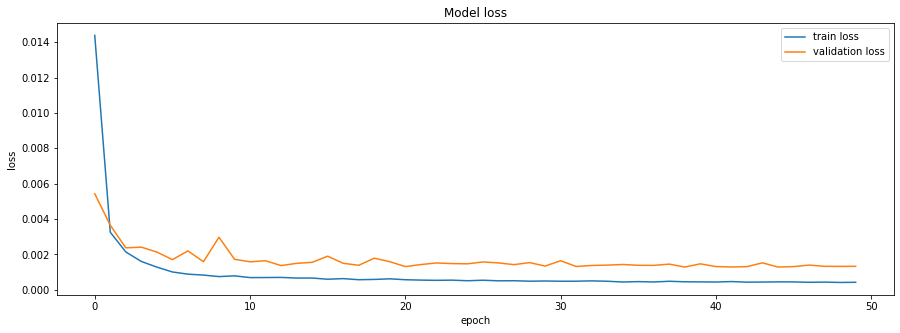

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [ ]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [ ]:
print(pred.tolist())

[[65095.1796875], [62390.9921875], [61905.78125], [61859.12890625], [59209.97265625], [53381.953125], [49726.7421875], [50876.78515625], [49715.48828125], [40325.765625], [37107.1484375], [33534.4296875], [31094.890625], [29693.1328125], [29021.046875], [28041.24609375], [27650.3359375], [28791.7734375], [28845.919921875], [30267.96875], [35996.921875], [46263.52734375], [51114.2265625], [52397.921875], [52285.34375], [51076.453125], [48388.26953125], [48639.6796875], [48805.7265625], [48171.29296875], [49658.1328125], [51442.26953125], [51168.2734375], [42235.40234375], [37889.55078125], [34427.40625], [32253.48046875], [31056.501953125], [29400.98046875], [28628.794921875], [27635.634765625], [28567.0859375], [28944.9921875], [29391.19140625], [29878.46875], [37548.0234375], [45941.046875], [47549.09765625], [46788.16015625], [46928.640625], [47063.7265625], [47025.015625], [47167.64453125], [46653.81640625], [47529.0], [50220.27734375], [49582.640625], [41332.18359375], [36520.58593

In [ ]:
print(hist.history['loss'])

[0.014389348216354847, 0.0032487749122083187, 0.002134650480002165, 0.0015952630201354623, 0.0012742109829559922, 0.0010013502324, 0.000876985490322113, 0.0008247121586464345, 0.0007389785605482757, 0.000781143840868026, 0.0006825049058534205, 0.0006856206455267966, 0.0006930068484507501, 0.0006554443971253932, 0.0006567745003849268, 0.0005897930241189897, 0.0006240932270884514, 0.0005622177268378437, 0.0005785598186776042, 0.0006125179352238774, 0.0005618080613203347, 0.0005403321119956672, 0.0005275438306853175, 0.0005376802873797715, 0.0005048836464993656, 0.0005336790927685797, 0.0004996117204427719, 0.0005056843510828912, 0.000478853820823133, 0.0004898489569313824, 0.00047637568786740303, 0.0004777582362294197, 0.0004970033187419176, 0.0004760837182402611, 0.00043268001172691584, 0.0004555672931019217, 0.00043470371747389436, 0.0004743080062326044, 0.00044485105900093913, 0.00043849239591509104, 0.000430968648288399, 0.0004587754956446588, 0.00042346352711319923, 0.00043063351768

In [ ]:
print(hist.history['val_loss'])

[0.005428579170256853, 0.003644666401669383, 0.0023651360534131527, 0.0024052804801613092, 0.0021286355331540108, 0.0016985771944746375, 0.00219172821380198, 0.0015823611756786704, 0.002965949010103941, 0.0017198073910549283, 0.0015759445959702134, 0.0016348413191735744, 0.001361855654977262, 0.0014877784997224808, 0.0015465678879991174, 0.001892898348160088, 0.001490372116677463, 0.0013790152734145522, 0.0017805407987907529, 0.0015824426664039493, 0.001305685262195766, 0.0014195237308740616, 0.0015105979982763529, 0.001474391552619636, 0.0014616335975006223, 0.0015671224100515246, 0.0015128916129469872, 0.00141518481541425, 0.001530555309727788, 0.0013340840814635158, 0.001635611872188747, 0.0013120166258886456, 0.0013667537132278085, 0.001388360047712922, 0.0014234005939215422, 0.0013780886074528098, 0.0013742242008447647, 0.0014439348597079515, 0.0012783349957317114, 0.0014613555977120996, 0.0013065011007711291, 0.0012823747238144279, 0.0013017425080761313, 0.0015184974763542414, 0.

WINDOWS SIZE = 108


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12155, 108, 1) (12155, 108, 108, 1) (12155, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2520, 108, 1) (2520, 108, 108, 1) (2520, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2520, 108, 1) (2520, 108, 108, 1) (2520, 1)
LOAD INPUTS  (None, 108, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 108, 108, 1)
CONVO BLOCK  (None, 104, 104, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
380/380 [==============================] - 11s 17ms/step - loss: 0.0145 - val_loss: 0.0037
Epoch 2/50
380/380 [==============================] - 5s 14ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 3/50
380/380 [==============================] - 5s 14ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 4/50
380/380 [==============================] - 5s 13ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 5/50
380/380 [=====================

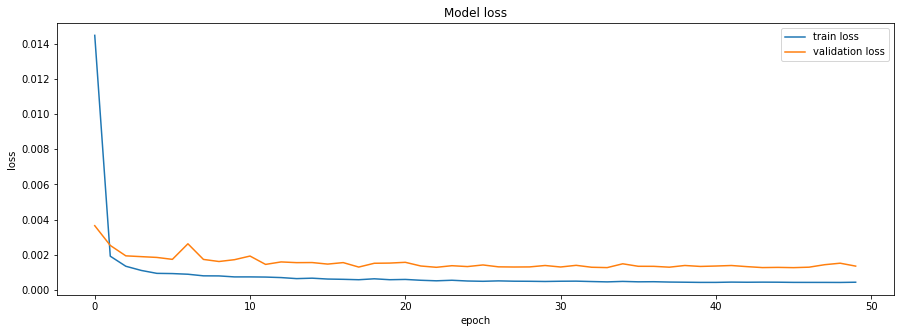

In [ ]:
#@title
LOOKBACK=108
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

WINDOW SIZE =120


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12143, 120, 1) (12143, 120, 120, 1) (12143, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2508, 120, 1) (2508, 120, 120, 1) (2508, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2508, 120, 1) (2508, 120, 120, 1) (2508, 1)
LOAD INPUTS  (None, 120, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 120, 120, 1)
CONVO BLOCK  (None, 116, 116, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
380/380 [==============================] - 9s 18ms/step - loss: 0.0137 - val_loss: 0.0053
Epoch 2/50
380/380 [==============================] - 6s 16ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 3/50
380/380 [==============================] - 7s 20ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/50
380/380 [==============================] - 6s 15ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/50
380/380 [======================

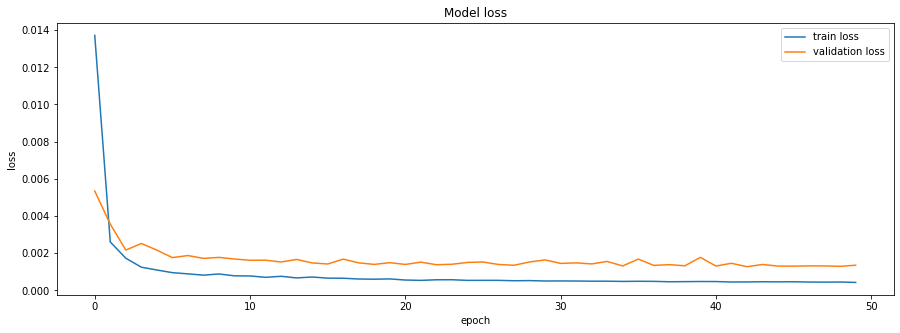

In [ ]:
#@title
LOOKBACK=120
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

WINDOW SIZE = 132


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12131, 132, 1) (12131, 132, 132, 1) (12131, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2496, 132, 1) (2496, 132, 132, 1) (2496, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2496, 132, 1) (2496, 132, 132, 1) (2496, 1)
LOAD INPUTS  (None, 132, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 132, 132, 1)
CONVO BLOCK  (None, 128, 128, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
380/380 [==============================] - 9s 19ms/step - loss: 0.0144 - val_loss: 0.0064
Epoch 2/50
380/380 [==============================] - 6s 15ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/50
380/380 [==============================] - 6s 17ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 4/50
380/380 [==============================] - 6s 15ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/50
380/380 [======================

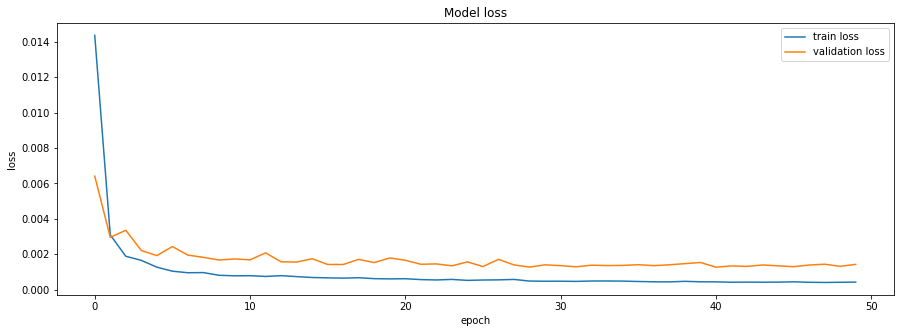

In [ ]:
#@title
LOOKBACK=132
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

#BASELINE MODEL TRAINING#

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

RANDOMFORESTREGRESSOR

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

train_X_load = train_X_load.reshape(-1,train_X_load.shape[1]*train_X_load.shape[2])
train_y = train_y.reshape(-1,train_y.shape[1]*train_y.shape[2])
val_X_load = val_X_load.reshape(-1,val_X_load.shape[1]*val_X_load.shape[2])
val_y = val_y.reshape(-1,val_y.shape[1]*val_y.shape[2])
test_X_load = test_X_load.reshape(-1,test_X_load.shape[1]*test_X_load.shape[2])
test_y = test_y.reshape(-1,test_y.shape[1]*test_y.shape[2])
print("\nShape of Train_X_load, and Train_y are\n", train_X_load.shape, train_y.shape)
print("\nShape of Val_X_load, and Val_y are\n", val_X_load.shape, val_y.shape)
print("\nShape of Test_X_load, and Test_y are\n", test_X_load.shape, test_y.shape)

model = RandomForestRegressor(n_estimators=200,
                              max_depth=110,
                              min_samples_split=8,
                              min_samples_leaf=3,
                              max_features=3,
                              bootstrap=True
                              )

start_time = time.time()
model.fit(train_X_load, train_y)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict(test_X_load)
pred = load_scaler.inverse_transform(np.array(pred_y).reshape(-1,1))
actu = load_scaler.inverse_transform(np.array(test_y).reshape(-1,1))
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print('\nEvaluation metric results:-\n')
print("WINDOW SIZE ===> ",LOOKBACK)
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, and Train_y are
 (12167, 96) (12167, 1)

Shape of Val_X_load, and Val_y are
 (2532, 96) (2532, 1)

Shape of Test_X_load, and Test_y are
 (2532, 96) (2532, 1)


<ipython-input-16-479a3bd57155>:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X_load, train_y)



Evaluation metric results:-

WINDOW SIZE ===>  96
MAE is : 1597.462774334293
MAPE is : 3.58518336272995
R2 is : 0.9690996509786336
Convergence time is : 00:00:08
 -------------------------



In [ ]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [ ]:
print(pred.tolist())

[[59644.54831505991], [60195.13293093018], [60664.824983197366], [61153.623915542805], [59306.2704877067], [52512.404028013654], [49840.05561845098], [50415.211571969696], [49118.848135912696], [42156.88629774392], [37106.26461746659], [33175.803163557845], [31186.69551241977], [29587.6852262876], [28608.73953986618], [27873.9210886695], [27534.583423739652], [28055.73919916196], [30743.11835575781], [35792.08467395799], [43465.17434330945], [52828.05361961649], [58382.217220689054], [59679.57592792626], [59324.17018038909], [58142.05275679388], [55494.660892107895], [53988.41722444222], [50945.006778360534], [48413.8293471251], [48061.781279510535], [49154.00751103506], [49115.12248209176], [42905.63101247365], [37241.060527923466], [33849.97757501541], [31611.52434404485], [30046.09070698051], [29018.778843101707], [28139.13166805417], [27732.15721983776], [28245.302786456603], [29491.04468785381], [31954.125421085137], [37124.31306106649], [44142.925855470916], [49501.16734938672], 

SUPPORT VECTOR REGRESSOR

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

train_X_load = train_X_load.reshape(-1,train_X_load.shape[1]*train_X_load.shape[2])
train_y = train_y.reshape(-1,train_y.shape[1]*train_y.shape[2])
val_X_load = val_X_load.reshape(-1,val_X_load.shape[1]*val_X_load.shape[2])
val_y = val_y.reshape(-1,val_y.shape[1]*val_y.shape[2])
test_X_load = test_X_load.reshape(-1,test_X_load.shape[1]*test_X_load.shape[2])
test_y = test_y.reshape(-1,test_y.shape[1]*test_y.shape[2])
print("\nShape of Train_X_load, and Train_y are\n", train_X_load.shape, train_y.shape)
print("\nShape of Val_X_load, and Val_y are\n", val_X_load.shape, val_y.shape)
print("\nShape of Test_X_load, and Test_y are\n", test_X_load.shape, test_y.shape)

model = SVR(kernel='rbf',gamma=0.5, C=1e3, epsilon = 0.01)

start_time = time.time()
model.fit(train_X_load, train_y)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict(test_X_load)
pred = load_scaler.inverse_transform(np.array(pred_y).reshape(-1,1))
actu = load_scaler.inverse_transform(np.array(test_y).reshape(-1,1))
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print('\nEvaluation metric results:-\n')
print("WINDOW SIZE ===> ",LOOKBACK)
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, and Train_y are
 (12167, 96) (12167, 1)

Shape of Val_X_load, and Val_y are
 (2532, 96) (2532, 1)

Shape of Test_X_load, and Test_y are
 (2532, 96) (2532, 1)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Evaluation metric results:-

WINDOW SIZE ===>  96
MAE is : 1076.699285695866
MAPE is : 2.5313767334494175
R2 is : 0.9877840755935506
Convergence time is : 00:01:22
 -------------------------



In [ ]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [ ]:
print(pred.tolist())

[[63217.393211389404], [61108.13032293497], [61475.61752587203], [63569.20101774021], [59845.249491818075], [53737.22506101169], [51610.76978634739], [52501.80859861656], [51108.93054941852], [42610.40427709389], [36577.717549007815], [30941.13226846193], [29472.97765480094], [31390.09633018774], [30108.1914486001], [28166.194290372172], [28591.80989529165], [29481.978629204223], [29004.92123183042], [30504.41307834243], [38452.179108307646], [46743.376415631596], [52479.91253780242], [53172.38662615305], [53289.07596095067], [51181.40462101183], [48786.652458606506], [48042.18137634805], [48280.972582832714], [49713.0137671719], [51288.688322750335], [53611.50863023008], [51495.9044861722], [43777.44985336623], [36952.47066739038], [34017.528132004634], [33205.03465768465], [30890.21028625352], [30258.33783644624], [29450.32759781926], [28744.079420104834], [28486.71202740937], [30059.648576443393], [29884.632059260894], [35059.00843647459], [43760.43290303242], [50601.98169063227], [

ANN


Train-size ->12263, Validation-size ->2628, Test-size->2628
(12167, 96, 1) (12167, 96, 1) (12167, 1, 1)

Shape of Train_X_load, and Train_y are
 (12167, 96) (12167, 1)

Shape of Val_X_load, and Val_y are
 (2532, 96) (2532, 1)

Shape of Test_X_load, and Test_y are
 (2532, 96) (2532, 1)
INPUTS  (None, 96)
Epoch 1/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0045
Epoch 2/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 3/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 4/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 6/50
381/381 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 7/50
381/381 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0

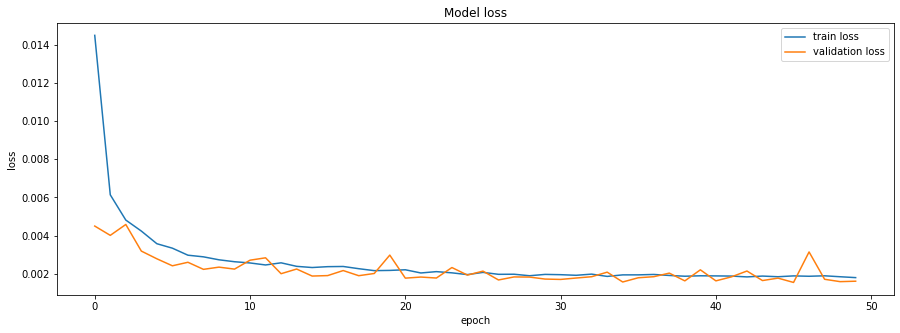

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

print(train_X_load.shape, train_X_temp.shape, train_y.shape)

train_X_load = train_X_load.reshape(-1,train_X_load.shape[1]*train_X_load.shape[2])
#train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(-1,val_X_load.shape[1]*val_X_load.shape[2])
#val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(-1,test_X_load.shape[1]*test_X_load.shape[2])
#test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(-1,train_y.shape[1]*train_y.shape[2])
val_y = val_y.reshape(-1,val_y.shape[1]*val_y.shape[2])
test_y = test_y.reshape(-1,test_y.shape[1]*test_y.shape[2])
print("\nShape of Train_X_load, and Train_y are\n", train_X_load.shape, train_y.shape)
print("\nShape of Val_X_load, and Val_y are\n", val_X_load.shape, val_y.shape)
print("\nShape of Test_X_load, and Test_y are\n", test_X_load.shape, test_y.shape)

inputs = layers.Input(shape=(LOOKBACK))

print("INPUTS ",inputs.shape)
x = layers.Dense(units = 50)(inputs)
x = layers.Activation("relu")(x)
x = layers.Dense(units = 32)(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation("relu")(x)
outputs = layers.Dense(1)(x)      
model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit(train_X_load, train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=(val_X_load,val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict(test_X_load)
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [ ]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [ ]:
print(pred.tolist())

[[63494.8515625], [61979.453125], [62276.90625], [62503.890625], [59276.50390625], [52350.19921875], [49341.06640625], [51452.2890625], [51088.6640625], [43314.640625], [36850.08984375], [34359.77734375], [32197.123046875], [30555.111328125], [30385.15234375], [29648.873046875], [28690.623046875], [29053.20703125], [30448.0859375], [33418.359375], [38094.984375], [45254.3828125], [50560.28125], [51130.4140625], [51062.56640625], [50446.08203125], [49211.78515625], [49275.16796875], [48336.48046875], [47492.69140625], [46502.453125], [50131.16015625], [51079.7265625], [44534.5], [37693.48828125], [35166.515625], [32949.50390625], [31612.17578125], [30410.083984375], [29392.962890625], [28544.927734375], [28647.853515625], [29105.556640625], [29842.716796875], [31061.763671875], [35479.58984375], [44296.92578125], [47011.65234375], [46242.421875], [45825.96484375], [46860.8515625], [47927.15625], [47915.83203125], [47387.11328125], [47621.97265625], [49829.3515625], [50094.75390625], [44

In [ ]:
print(hist.history['val_loss'])

[0.004499166272580624, 0.004011647310107946, 0.004582041874527931, 0.003187700407579541, 0.002783584175631404, 0.002416420029476285, 0.0026010239962488413, 0.0022302449215203524, 0.002346241381019354, 0.0022434520069509745, 0.002710249274969101, 0.002834954531863332, 0.0020023263059556484, 0.002246718853712082, 0.0018790045287460089, 0.0019031602423638105, 0.002167216269299388, 0.0018974076956510544, 0.002013699384406209, 0.002976722549647093, 0.0017696660943329334, 0.001826776540838182, 0.0017754817381501198, 0.002325308509171009, 0.001929718884639442, 0.002137287985533476, 0.0016737404512241483, 0.0018326598219573498, 0.0018257600022479892, 0.0017208998324349523, 0.0017020620871335268, 0.001775432494468987, 0.0018441122956573963, 0.0020825741812586784, 0.0015677014598622918, 0.0017892335308715701, 0.0018454561941325665, 0.002032739808782935, 0.0016265710582956672, 0.0022053574211895466, 0.0016269661718979478, 0.0018371496116742492, 0.0021423737052828074, 0.0016431701369583607, 0.0017

In [ ]:
print(hist.history['loss'])

[0.014494011178612709, 0.0061368863098323345, 0.0048130108043551445, 0.004236696753650904, 0.0035739599261432886, 0.0033397930674254894, 0.002971924841403961, 0.002886025467887521, 0.00273065734654665, 0.0026300062891095877, 0.0025648430455476046, 0.002460357267409563, 0.002572259632870555, 0.0023879320360720158, 0.0023258959408849478, 0.0023709521628916264, 0.00238108541816473, 0.002264438197016716, 0.002162763150408864, 0.0021746326237916946, 0.0022080503404140472, 0.0020406502299010754, 0.0021106943022459745, 0.002047345507889986, 0.0019545909017324448, 0.002071543363854289, 0.0019694569054991007, 0.0019744487944990396, 0.0018950506346300244, 0.001965499250218272, 0.0019504994852468371, 0.0019188581500202417, 0.0019798236899077892, 0.0018604015931487083, 0.0019406424835324287, 0.0019414746202528477, 0.001962958602234721, 0.0019099906785413623, 0.0018699561478570104, 0.0018930078949779272, 0.0018865310121327639, 0.0018776896176859736, 0.0018347202567383647, 0.0018779408419504762, 0.0

LSTM


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X and Train_y are
 (12167, 96, 1) (12167, 1)

Shape of Val_X and Val_y are
 (2532, 96, 1) (2532, 1)

Shape of Test_X and Test_y are
 (2532, 96, 1) (2532, 1)
INPUTS  (None, 96, 1)
(None, 50)
LSTM OUT  (None, 32)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 6s 11ms/step - loss: 0.0147 - val_loss: 0.0041
Epoch 2/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 3/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 4/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 5/50
381/381 [==============================] - 3s 8ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 6/50
381/381 [==============================] - 3s 8ms/step - loss: 9.6081e-04 - val_loss: 0.0019
Epoch 7/50
381/381 [==============================] - 3s 7ms/step - loss: 8.9501e-04 - va

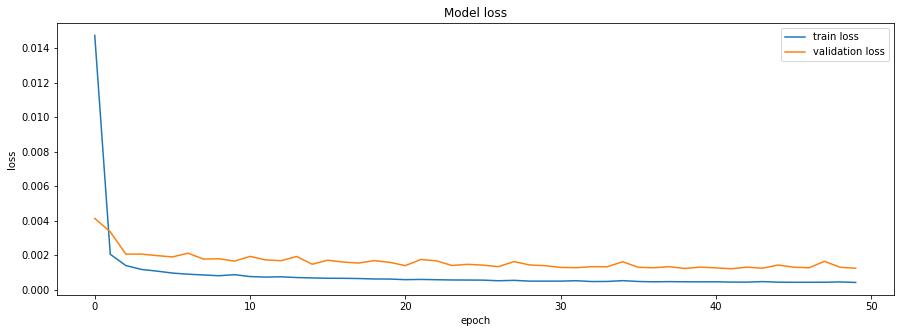

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

train_X = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
val_X = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
test_X = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X and Train_y are\n", train_X.shape,  train_y.shape)
print("\nShape of Val_X and Val_y are\n", val_X.shape,  val_y.shape)
print("\nShape of Test_X and Test_y are\n", test_X.shape,  test_y.shape)

inputs = layers.Input(shape=(LOOKBACK,1))

print("INPUTS ",inputs.shape)
x = layers.LSTM(50, return_sequences=False)(inputs)
print(x.shape)
x = layers.Dense(32, activation='relu')(x)
print("LSTM OUT ",x.shape)
outputs = layers.Dense(1, activation='relu')(x)
print("Output ",outputs.shape)

model = Model(inputs=inputs, outputs = outputs, name="LSTM-NoTempImage")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit(train_X, train_y, epochs=50, steps_per_epoch=steps(train_X.shape[0]),
  validation_steps=steps(val_X.shape[0]), validation_data=(val_X,val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict(test_X)
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [ ]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [ ]:
print(pred.tolist())

[[65578.1171875], [62849.23046875], [62370.421875], [62443.69140625], [59634.2734375], [53316.30078125], [50377.453125], [51524.44921875], [49934.90625], [40739.0], [37515.55859375], [33527.46484375], [31243.8125], [29864.390625], [29311.4609375], [28192.25], [27980.02734375], [29318.9609375], [27920.171875], [29168.962890625], [35063.453125], [45984.6640625], [50422.328125], [52211.9921875], [52044.234375], [50662.75], [47833.42578125], [48600.80078125], [49262.85546875], [47887.23046875], [49606.625], [52097.625], [52154.45703125], [42369.09765625], [38248.0078125], [34518.15625], [32351.0546875], [31111.576171875], [29628.455078125], [28811.6953125], [28054.34375], [29126.728515625], [28388.591796875], [28709.439453125], [28628.869140625], [36235.4140625], [45263.6328125], [46442.2578125], [46198.046875], [46285.11328125], [46563.24609375], [46716.9609375], [47001.0390625], [46816.5703125], [47530.796875], [50688.30859375], [50988.29296875], [42685.60546875], [36976.04296875], [3396

In [ ]:
print(hist.history['loss'])

[0.014732575044035912, 0.0020475888159126043, 0.0013974609319120646, 0.0011720109032467008, 0.001074023311957717, 0.0009608124964870512, 0.0008950071060098708, 0.0008508373284712434, 0.000805445306468755, 0.0008669309318065643, 0.000758394889999181, 0.0007259036065079272, 0.0007443657959811389, 0.0007012448040768504, 0.000677854404784739, 0.0006595939048565924, 0.0006557623273693025, 0.0006431695073843002, 0.0006171871209517121, 0.0006135412841103971, 0.0005775426980108023, 0.0005909157334826887, 0.0005750290583819151, 0.0005597230629064143, 0.0005563260056078434, 0.0005509534385055304, 0.0005149575299583375, 0.000538526161108166, 0.0004928551497869194, 0.0004926588735543191, 0.0004938030615448952, 0.000516504340339452, 0.00046989505062811077, 0.0004751421802211553, 0.0005208777729421854, 0.00047331879613921046, 0.0004530829028226435, 0.000465606979560107, 0.0004547960124909878, 0.0004514130123425275, 0.00045434210915118456, 0.0004373363044578582, 0.0004350622766651213, 0.0004660087579

In [ ]:
print(hist.history['val_loss'])

[0.004126918967813253, 0.003349989652633667, 0.002060147002339363, 0.0020595602691173553, 0.0019729575142264366, 0.0018944642506539822, 0.002112783258780837, 0.0017726937076076865, 0.0017908003646880388, 0.001652874518185854, 0.0019263543654233217, 0.0017228638753294945, 0.0016778444405645132, 0.001921632676385343, 0.0014717725571244955, 0.0017046004068106413, 0.0015982307959347963, 0.0015408649342134595, 0.0016818565782159567, 0.0015819784021005034, 0.0013921060599386692, 0.001745686517097056, 0.0016696755774319172, 0.0014001756208017468, 0.0014656560961157084, 0.0014201919548213482, 0.001333709224127233, 0.0016247167950496078, 0.0014305042568594217, 0.0013892954448238015, 0.0012884305324405432, 0.0012722682440653443, 0.0013302835868671536, 0.001324039651080966, 0.001618227455765009, 0.001294011133722961, 0.001269959262572229, 0.001330111874267459, 0.0012278342619538307, 0.0013046112144365907, 0.0012616413878276944, 0.0012082639150321484, 0.0013031299458816648, 0.0012429285561665893, 

**GRU**


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X and Train_y are
 (12167, 96, 1) (12167, 1)

Shape of Val_X and Val_y are
 (2532, 96, 1) (2532, 1)

Shape of Test_X and Test_y are
 (2532, 96, 1) (2532, 1)
INPUTS  (None, 96, 1)
(None, 50)
LSTM OUT  (None, 32)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 40s 8ms/step - loss: 0.0102 - val_loss: 0.0039
Epoch 2/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 3/50
381/381 [==============================] - 4s 10ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 4/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 5/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/50
381/381 [==============================] - 3s 8ms/step - loss: 0.0012 - val_loss:

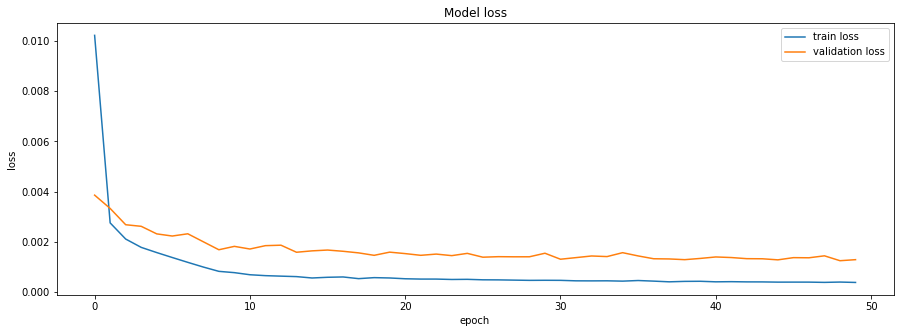

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

train_X = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
val_X = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
test_X = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X and Train_y are\n", train_X.shape,  train_y.shape)
print("\nShape of Val_X and Val_y are\n", val_X.shape,  val_y.shape)
print("\nShape of Test_X and Test_y are\n", test_X.shape,  test_y.shape)

inputs = layers.Input(shape=(LOOKBACK,1))

print("INPUTS ",inputs.shape)
x = layers.GRU(50, return_sequences=False)(inputs)
print(x.shape)
x = layers.Dense(32, activation='relu')(x)
print("LSTM OUT ",x.shape)
outputs = layers.Dense(1, activation='relu')(x)
print("Output ",outputs.shape)

model = Model(inputs=inputs, outputs = outputs, name="LSTM-NoTempImage")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit(train_X, train_y, epochs=50, steps_per_epoch=steps(train_X.shape[0]),
  validation_steps=steps(val_X.shape[0]), validation_data=(val_X,val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict(test_X)
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [ ]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [ ]:
print(pred.tolist())

[[64867.34765625], [62307.6640625], [62613.21875], [62111.55078125], [59296.65234375], [52737.54296875], [49267.35546875], [51861.2265625], [49895.5703125], [40888.2109375], [37563.62890625], [33760.140625], [31014.767578125], [30069.048828125], [29214.76953125], [28088.015625], [27694.974609375], [28602.33984375], [28463.828125], [29318.08203125], [36096.8359375], [45914.9765625], [49793.33203125], [51333.12109375], [51439.75], [50110.2734375], [48422.640625], [48463.4375], [48680.08984375], [47982.09375], [49469.5859375], [52379.2421875], [51652.6953125], [41487.02734375], [38408.171875], [34849.046875], [32015.25390625], [31248.544921875], [29540.591796875], [28682.10546875], [27925.50390625], [28335.53515625], [29231.658203125], [28801.84765625], [27616.376953125], [36452.390625], [44749.74609375], [45566.9609375], [45819.92578125], [45931.47265625], [46178.5703125], [46314.875], [46851.6328125], [46579.25], [47444.9765625], [51388.2265625], [50213.27734375], [40724.19140625], [376

In [ ]:
print(hist.history['loss'])

[0.010221519507467747, 0.0027530707884579897, 0.002110100584104657, 0.0017784306546673179, 0.0015713288448750973, 0.001374714309349656, 0.0011820385698229074, 0.000995007692836225, 0.0008237637812271714, 0.0007720564608462155, 0.0006886701448820531, 0.0006524968193843961, 0.0006327271112240851, 0.0006141014164313674, 0.0005593989044427872, 0.0005872338660992682, 0.0006003915332257748, 0.0005329539417289197, 0.0005731786950491369, 0.0005598643911071122, 0.000528445583768189, 0.0005158840212970972, 0.0005156368715688586, 0.0005001726094633341, 0.0005055138026364148, 0.00048677928862161934, 0.00048374771722592413, 0.00047431373968720436, 0.00046475487761199474, 0.0004680016718339175, 0.0004653252544812858, 0.0004461329954210669, 0.00044408399844542146, 0.00044681382132694125, 0.00043385743629187346, 0.0004583857371471822, 0.0004343225446064025, 0.0004066386609338224, 0.0004241187998559326, 0.0004281192668713629, 0.00040671133319847286, 0.00041247476474381983, 0.0004042192595079541, 0.0004

In [ ]:
print(hist.history['val_loss'])

[0.0038586053997278214, 0.003329101949930191, 0.0026801442727446556, 0.0026170930359512568, 0.0023158916737884283, 0.0022301238495856524, 0.0023193946108222008, 0.0020012313034385443, 0.001683892565779388, 0.0018187136156484485, 0.0017129508778452873, 0.0018467861227691174, 0.0018652192084118724, 0.0015842157881706953, 0.0016395564889535308, 0.0016718370607122779, 0.0016227798769250512, 0.0015590534312650561, 0.001461676904000342, 0.0015881871804594994, 0.0015303189866244793, 0.0014620688743889332, 0.0015109259402379394, 0.0014495003269985318, 0.0015396947273984551, 0.001387115684337914, 0.0014080072287470102, 0.0014028766890987754, 0.0014037340879440308, 0.0015450342325493693, 0.0013063872465863824, 0.001370588201098144, 0.0014356188476085663, 0.001411743345670402, 0.0015671668807044625, 0.0014379732310771942, 0.001325393794104457, 0.001317574642598629, 0.0012889290228486061, 0.0013381076278164983, 0.0013966141268610954, 0.0013735252432525158, 0.00132844562176615, 0.001324248500168323

**LOAD SEQUENCE N TEMPERATURE SEQUENCE (LSTS)**


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12167, 96, 1) (12167, 96, 1) (12167, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2532, 96, 1) (2532, 96, 1) (2532, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2532, 96, 1) (2532, 96, 1) (2532, 1)
LOAD INPUTS  (None, 96, 1)
TEMP INPUTS  (None, 96, 1)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 8s 15ms/step - loss: 0.0134 - val_loss: 0.0043
Epoch 2/50
381/381 [==============================] - 5s 12ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 3/50
381/381 [==============================] - 4s 11ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 4/50
381/381 [==============================] - 5s 14ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/50
381/381 [==============================] - 4s 11ms/step - loss: 9.4238e-04 - val_loss: 0.0020
Epoch 6/50
381/381 [==============================] - 4s 11ms/step -

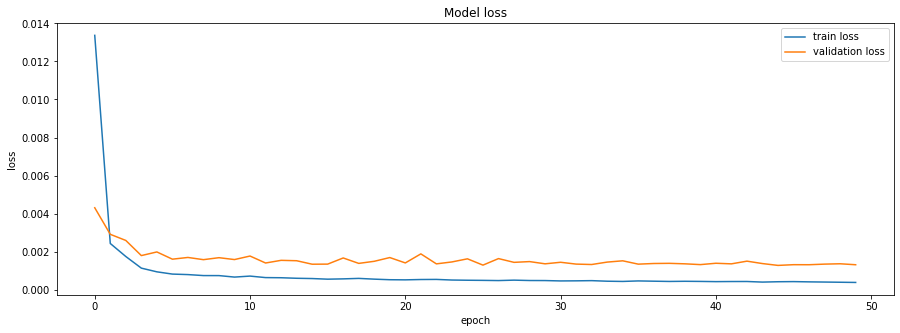

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.LSTM(50, return_sequences=False)(load_inputs)
x1 = layers.Dense(32, activation='relu')(x1)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.LSTM(50, return_sequences=False)(temp_inputs)
x2 = layers.Dense(32,activation='relu')(x2)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [ ]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [ ]:
print(pred.tolist())

[[64494.6328125], [62029.546875], [61687.69921875], [61530.3203125], [59014.734375], [52489.78515625], [49068.953125], [50913.75390625], [49881.37109375], [41701.29296875], [37743.25390625], [33857.41015625], [31522.072265625], [30262.142578125], [29541.072265625], [28413.517578125], [27898.484375], [28650.3515625], [28221.2109375], [28901.287109375], [35052.69921875], [44858.3828125], [50115.03125], [51267.57421875], [51292.02734375], [50348.93359375], [47658.28515625], [47864.546875], [48288.8671875], [47132.42578125], [48263.33203125], [51036.8984375], [51747.5625], [42863.6640625], [38561.375], [35010.140625], [32825.46484375], [31627.220703125], [30011.666015625], [29023.82421875], [27990.421875], [28159.8828125], [28025.783203125], [27816.541015625], [27906.98828125], [36203.06640625], [44292.5], [45334.625], [45869.40625], [45976.55078125], [46006.609375], [46062.453125], [46471.59375], [45949.59765625], [46818.33203125], [49699.23046875], [50209.80859375], [42578.29296875], [37

In [ ]:
print(hist.history['loss'])

[0.013370371423661709, 0.0024324979167431593, 0.0017481163376942277, 0.001136627746745944, 0.0009423830197192729, 0.0008237264701165259, 0.0007973303436301649, 0.0007452394347637892, 0.0007440418703481555, 0.0006660848157480359, 0.0007184180431067944, 0.0006394244846887887, 0.0006318306550383568, 0.000603593303821981, 0.000589169969316572, 0.0005561686703003943, 0.0005721397465094924, 0.000597256061155349, 0.0005576249095611274, 0.0005275017465464771, 0.0005208427901379764, 0.000538261141628027, 0.0005436346982605755, 0.000511160702444613, 0.0005003692931495607, 0.0004936108598485589, 0.0004830583347938955, 0.0005050272447988391, 0.0004860424960497767, 0.00048362393863499165, 0.00046386258327402174, 0.00046911233221180737, 0.0004791335668414831, 0.00044915699982084334, 0.00043747402378357947, 0.0004641176201403141, 0.0004500338400248438, 0.00043699447996914387, 0.00044526017154566944, 0.00043845834443345666, 0.00042724257218651474, 0.00043285859283059835, 0.00043451497913338244, 0.0004

In [ ]:
print(hist.history['val_loss'])

[0.004309236537665129, 0.002913759322836995, 0.0025915910955518484, 0.001795923919416964, 0.0019874763675034046, 0.0016073534497991204, 0.0016979494830593467, 0.001581943011842668, 0.001685596420429647, 0.001587164937518537, 0.0017721595941111445, 0.0014061022084206343, 0.0015462663723155856, 0.0015256775077432394, 0.001342704170383513, 0.00134746462572366, 0.0016709852498024702, 0.001385773764923215, 0.001495708362199366, 0.001692545018158853, 0.0014104086440056562, 0.0018856320530176163, 0.0013610882451757789, 0.0014620001893490553, 0.0016259425319731236, 0.0012948446674272418, 0.0016380005981773138, 0.0014402670785784721, 0.0014803496887907386, 0.00136328034568578, 0.0014445363776758313, 0.0013483697548508644, 0.0013269083574414253, 0.001453983597457409, 0.0015213595470413566, 0.0013460631016641855, 0.0013800340238958597, 0.0013888069661334157, 0.0013629592722281814, 0.0013216105289757252, 0.001392757403664291, 0.0013615780044347048, 0.0015034149400889874, 0.0013762390008196235, 0.0

**LOAD IMAGED N TEMPERATURE IMAGED (LITI)**


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12167, 96, 96, 1) (12167, 96, 96, 1) (12167, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2532, 96, 96, 1) (2532, 96, 96, 1) (2532, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2532, 96, 96, 1) (2532, 96, 96, 1) (2532, 1)
LOAD INPUTS  (None, 96, 96, 1)
CONVO BLOCK1  (None, 92, 92, 32)
Pool1  (None, 32)
CNN1 OUT  (None, 32)
TEMP INPUTS  (None, 96, 96, 1)
CONVO2 BLOCK2  (None, 92, 92, 32)
Pool2  (None, 32)
CNN2 OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 6s 16ms/step - loss: 0.0665 - val_loss: 0.0628
Epoch 2/50
381/381 [==============================] - 5s 14ms/step - loss: 0.0626 - val_loss: 0.0571
Epoch 3/50
381/381 [==============================] - 5s 14ms/step - loss: 0.0571 - val_loss: 0.0499
Epoch 4/50
381/381 [==============================] - 5s 14ms/step - loss: 0.0487 - val_loss: 0.0

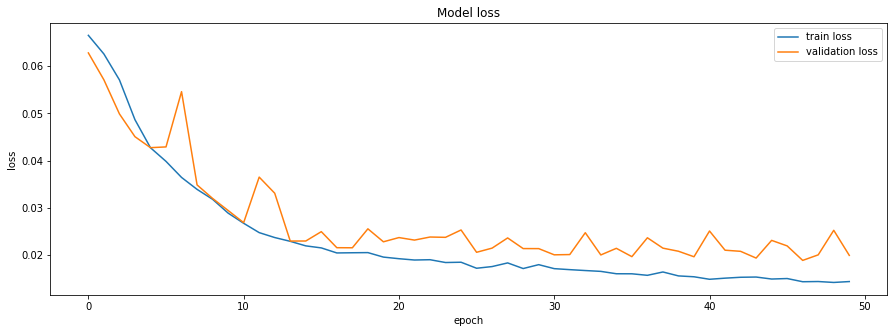

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)

train_X_load = transformer.transform(train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1]))
val_X_load = transformer.transform(val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1]))
test_X_load = transformer.transform(test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1]))

train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],train_X_load.shape[2],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],val_X_load.shape[2],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],test_X_load.shape[2],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(load_inputs)
x1 = layers.ReLU()(x1)
#x1 = layers.MaxPool2D()(x1)
print("CONVO BLOCK1 ",x1.shape)
x1 = layers.GlobalAvgPool2D()(x1)
print("Pool1 ",x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("CNN1 OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO2 BLOCK2 ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool2 ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN2 OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="LITI")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [ ]:
print(pred.tolist())

[[64246.40234375], [62424.77734375], [63585.46484375], [64775.8203125], [56697.55859375], [51564.97265625], [50955.35546875], [54926.875], [56213.69140625], [52521.69921875], [43312.69921875], [33562.05078125], [31672.50390625], [35197.609375], [39876.55078125], [39439.890625], [37711.140625], [34673.66015625], [32074.4453125], [34323.125], [39355.26171875], [45260.87890625], [45884.71484375], [48905.1953125], [47456.953125], [42687.328125], [44216.84375], [47644.0], [45306.5], [43066.90234375], [48872.1171875], [58193.00390625], [62519.58203125], [58719.5546875], [47149.03125], [34675.3203125], [34340.5390625], [36697.79296875], [38589.15234375], [38220.6328125], [35755.99609375], [32266.42578125], [31697.337890625], [34725.90625], [38202.9140625], [42226.890625], [47197.9296875], [54176.71875], [49596.67578125], [45478.75390625], [49963.7421875], [49790.65234375], [46350.8125], [46455.765625], [51940.90234375], [61472.23828125], [65358.05078125], [60068.46484375], [50127.16796875], [

In [ ]:
print(hist.history['loss'])

[0.06649161875247955, 0.0625533014535904, 0.057076700031757355, 0.04866313561797142, 0.0427350252866745, 0.03985220566391945, 0.03646029904484749, 0.033934567123651505, 0.03183670714497566, 0.02891666814684868, 0.026767676696181297, 0.024793364107608795, 0.02375340647995472, 0.022954311221837997, 0.021993938833475113, 0.02156306616961956, 0.02049732208251953, 0.020537303760647774, 0.020569493994116783, 0.019620347768068314, 0.01927962712943554, 0.019002607092261314, 0.01906643994152546, 0.01847320981323719, 0.01853431575000286, 0.017261799424886703, 0.017619436606764793, 0.01839112490415573, 0.01720031537115574, 0.01802184246480465, 0.017178228124976158, 0.016967017203569412, 0.016777999699115753, 0.016601063311100006, 0.016099315136671066, 0.016089752316474915, 0.015767429023981094, 0.016473745927214622, 0.01564357802271843, 0.01546043436974287, 0.014930731616914272, 0.015167375095188618, 0.015355472452938557, 0.015403792262077332, 0.014983239583671093, 0.015087606385350227, 0.0144126

In [ ]:
print(hist.history['val_loss'])

[0.06277694553136826, 0.05709114670753479, 0.049889739602804184, 0.045071277767419815, 0.04275131970643997, 0.04290919378399849, 0.05458848550915718, 0.034878164529800415, 0.0320187546312809, 0.029470795765519142, 0.026903020218014717, 0.036528103053569794, 0.033120375126600266, 0.02301064133644104, 0.023018766194581985, 0.024997692555189133, 0.021606547757983208, 0.021588066592812538, 0.025595394894480705, 0.022854026407003403, 0.023746391758322716, 0.023213816806674004, 0.0238619577139616, 0.02379762753844261, 0.025352852419018745, 0.020636513829231262, 0.021519199013710022, 0.023671625182032585, 0.021420584991574287, 0.02141152136027813, 0.020101139321923256, 0.020155226811766624, 0.024772940203547478, 0.020074522122740746, 0.02147468738257885, 0.01971563696861267, 0.023702925071120262, 0.021510183811187744, 0.020855415612459183, 0.01969129592180252, 0.02513265609741211, 0.02107751928269863, 0.02084004506468773, 0.01941554620862007, 0.023153532296419144, 0.021985584869980812, 0.0189

**P2DCNN-GRU**


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12167, 96, 1) (12167, 96, 96, 1) (12167, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2532, 96, 1) (2532, 96, 96, 1) (2532, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2532, 96, 1) (2532, 96, 96, 1) (2532, 1)
LOAD INPUTS  (None, 96, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 96, 96, 1)
CONVO BLOCK  (None, 92, 92, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 25s 13ms/step - loss: 0.0107 - val_loss: 0.0048
Epoch 2/50
381/381 [==============================] - 5s 13ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 3/50
381/381 [==============================] - 4s 11ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/50
381/381 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 5/50
381/381 [==============================] - 5

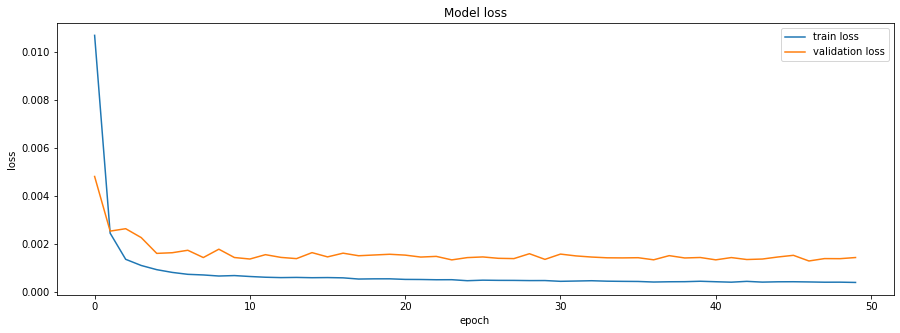

In [ ]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.GRU(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="COMBINED")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [ ]:
print(pred.tolist())

[[65769.7109375], [63367.953125], [62853.03515625], [62341.390625], [60260.75390625], [53911.73046875], [49267.875], [51475.41015625], [49311.2734375], [41392.390625], [37082.2578125], [33500.44921875], [31109.701171875], [29869.216796875], [28992.029296875], [27290.505859375], [27018.474609375], [28371.318359375], [27858.634765625], [29974.04296875], [36171.33984375], [46334.83203125], [50744.68359375], [52485.3828125], [52550.62890625], [51154.1796875], [49131.69140625], [48517.1953125], [49327.21875], [48389.1640625], [48828.1796875], [50862.140625], [51309.1484375], [42286.078125], [38371.7265625], [34742.12890625], [32430.970703125], [31291.37890625], [29467.212890625], [28056.58203125], [26925.623046875], [28102.3984375], [27758.6484375], [29078.4765625], [29814.869140625], [38577.07421875], [44859.28125], [46102.33984375], [46458.60546875], [46569.20703125], [47299.296875], [46759.26171875], [47258.9609375], [46479.17578125], [47605.43359375], [49834.421875], [49381.1171875], [4

In [ ]:
print(hist.history['loss'])

[0.010673025622963905, 0.0024338688235729933, 0.001345307333394885, 0.001088327495381236, 0.0009137162705883384, 0.0007994124316610396, 0.0007197210798040032, 0.0006934946868568659, 0.0006490087835118175, 0.0006677719065919518, 0.000629005953669548, 0.0005983889568597078, 0.0005830418667756021, 0.000590793788433075, 0.0005785724497400224, 0.0005845755804330111, 0.0005730455159209669, 0.0005232291296124458, 0.0005318200564943254, 0.0005326150567270815, 0.0005081742419861257, 0.0005044393474236131, 0.0004937384510412812, 0.0004958026693202555, 0.000453781831311062, 0.0004759670700877905, 0.00046834390377625823, 0.00046674543409608305, 0.00045893029891885817, 0.0004604673304129392, 0.0004280831490177661, 0.0004402578342705965, 0.0004530611913651228, 0.0004340635205153376, 0.0004268615157343447, 0.0004223418072797358, 0.000398837000830099, 0.0004098143253941089, 0.0004133781185373664, 0.0004308536590542644, 0.0004109102883376181, 0.0003926312201656401, 0.0004267752228770405, 0.000395022216

In [ ]:
print(hist.history['val_loss'])

[0.004795086570084095, 0.002519786125048995, 0.0026199284475296736, 0.0022499840706586838, 0.0015919009456411004, 0.001619371585547924, 0.0017216401174664497, 0.0014186401385813951, 0.001766169210895896, 0.0014198522549122572, 0.0013570180162787437, 0.0015384306898340583, 0.0014244606718420982, 0.0013735790271311998, 0.0016229554312303662, 0.001446032547391951, 0.001600839663296938, 0.0014935991493985057, 0.0015247869305312634, 0.0015551121905446053, 0.0015196913154795766, 0.0014387419214472175, 0.0014668104704469442, 0.0013210835168138146, 0.0014160771388560534, 0.001443831599317491, 0.001386604504659772, 0.0013745907926931977, 0.0015779988607391715, 0.0013423318741843104, 0.0015623824438080192, 0.0014864109689369798, 0.0014393022283911705, 0.0014079901156947017, 0.001403843518346548, 0.001411633682437241, 0.001324301934801042, 0.001497876481153071, 0.001400833367370069, 0.0014205069746822119, 0.0013224591966718435, 0.0014175273245200515, 0.0013363223988562822, 0.001356454216875136, 0

**1DCNN+LSTM**


Train-size ->12263, Validation-size ->2628, Test-size->2628
(32, 96, 2)
Epoch 1/50
381/381 [==============================] - 16s 9ms/step - loss: 0.0158 - val_loss: 0.0036
Epoch 2/50
381/381 [==============================] - 3s 7ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 3/50
381/381 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 4/50
381/381 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/50
381/381 [==============================] - 2s 6ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 6/50
381/381 [==============================] - 2s 6ms/step - loss: 9.3373e-04 - val_loss: 0.0020
Epoch 7/50
381/381 [==============================] - 2s 6ms/step - loss: 8.4022e-04 - val_loss: 0.0019
Epoch 8/50
381/381 [==============================] - 3s 7ms/step - loss: 8.1392e-04 - val_loss: 0.0018
Epoch 9/50
381/381 [==============================] - 3s 7ms/step - loss: 7.4423e-04 - val_loss: 0.0019
Epoch 10/5

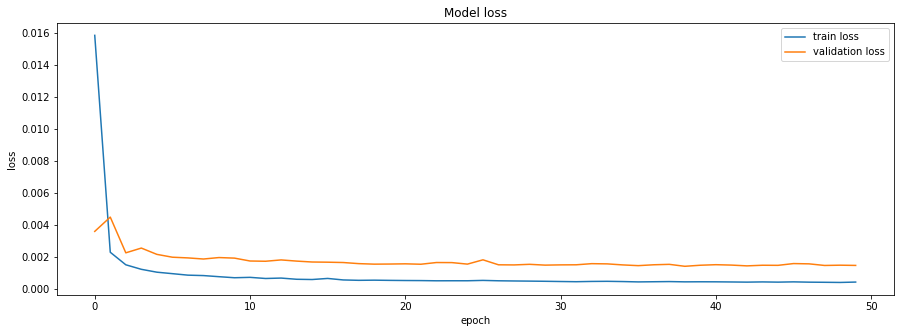

In [6]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

train_df_scaled = train_df.copy(deep=True)
val_df_scaled = val_df.copy(deep=True)
test_df_scaled = test_df.copy(deep=True)

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()

train_df_scaled["load"] = load_scaler.fit_transform(train_df[["load"]])
train_df_scaled["temperature"] = temp_scaler.fit_transform(train_df[["temperature"]])

val_df_scaled["load"] = load_scaler.transform(val_df[["load"]])
val_df_scaled["temperature"] = temp_scaler.transform(val_df[["temperature"]])

test_df_scaled["load"] = load_scaler.transform(test_df[["load"]])
test_df_scaled["temperature"] = temp_scaler.transform(test_df[["temperature"]])

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df_scaled), len(val_df_scaled), len(test_df_scaled)))

train_X, train_y = reframe2(train_df_scaled, 'load', LOOKBACK, HORIZON)
val_X, val_y = reframe2(val_df_scaled, 'load', LOOKBACK, HORIZON)
test_X, test_y = reframe2(test_df_scaled, 'load', LOOKBACK, HORIZON)

BUFFER_SIZE = 150
#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_data = val_data.batch(BATCH_SIZE).repeat()

test_data = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_data = test_data.batch(BATCH_SIZE).repeat()


for x, y in train_data.take(1):
  print (x.shape)

inputs = layers.Input(shape=(96,2))

# 1st CONV => RELU => POOL layer set
x = layers.Conv1D(64, kernel_size=3, padding="same")(inputs)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
# LSTM layer
x = layers.LSTM(units = 32, return_sequences=False)(x)
# FC => Outputs
x = layers.Dense(units = 48)(x)
x = layers.Activation("relu")(x)
# softmax classifier
outputs = layers.Dense(1)(x)
model = Model(inputs=inputs, outputs=outputs, name="1DCNNLSTM")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit(train_data, epochs=50, steps_per_epoch=steps(len(train_X)),
  validation_steps=steps(len(val_X)), validation_data=val_data, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict(test_X)
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [7]:
print(actu.tolist())

[[62719.00000000001], [61008.0], [61301.00000000001], [61916.99999999999], [60142.0], [52020.0], [49420.00000000001], [50849.0], [49305.0], [43121.0], [36599.0], [33310.0], [31287.0], [30315.0], [28900.000000000004], [28044.0], [28047.0], [27460.0], [28364.0], [30128.0], [35563.0], [44839.0], [51013.00000000001], [53027.00000000001], [52144.0], [48531.0], [48252.00000000001], [48788.00000000001], [48685.0], [48468.0], [49439.0], [52738.0], [50995.00000000001], [44267.0], [37694.0], [34756.0], [32905.0], [30724.0], [29673.0], [28183.0], [28142.0], [27733.0], [28248.0], [27683.0], [29461.999999999996], [38242.0], [44606.0], [45760.0], [46484.0], [46333.0], [46177.0], [46785.0], [46738.0], [46391.0], [47632.0], [50401.00000000001], [48617.0], [43013.0], [36882.0], [33523.0], [31714.0], [30139.0], [29125.000000000004], [28357.0], [28216.0], [28684.0], [31103.999999999996], [39549.0], [51625.0], [62604.99999999999], [68850.0], [69611.0], [69858.0], [69034.0], [68566.0], [67290.0], [64080.99

In [8]:
print(pred.tolist())

[[66179.2890625], [64044.93359375], [62661.0625], [62555.28515625], [59826.375], [52811.77734375], [48505.9765625], [49400.54296875], [49994.421875], [42579.91796875], [37299.515625], [34278.66796875], [31969.642578125], [30657.912109375], [29523.17578125], [28263.373046875], [27836.1015625], [28591.12890625], [29539.109375], [30584.673828125], [35465.06640625], [41475.484375], [48675.59765625], [52389.03515625], [52588.8984375], [51411.75390625], [48393.63671875], [48296.13671875], [48339.7734375], [47054.875], [47727.80859375], [50034.06640625], [51743.6796875], [44189.25], [38755.796875], [35712.75390625], [33416.33203125], [31711.73046875], [29842.447265625], [28836.802734375], [27916.564453125], [28481.328125], [29502.80859375], [29622.138671875], [30197.708984375], [33720.3671875], [39418.17578125], [44714.89453125], [46190.55078125], [45841.4453125], [46136.96484375], [45853.29296875], [45941.4375], [45751.97265625], [46775.25390625], [48980.51171875], [49074.57421875], [41415.1

In [9]:
print(hist.history['loss'])

[0.015844233334064484, 0.0022723369766026735, 0.0014885776909068227, 0.001205597072839737, 0.001025937614031136, 0.0009337275987491012, 0.0008402178063988686, 0.0008139223209582269, 0.000744229240808636, 0.0006784972501918674, 0.0007028258987702429, 0.0006316087092272937, 0.0006575751467607915, 0.0005826018750667572, 0.0005671970429830253, 0.0006347577436827123, 0.0005404859548434615, 0.0005167501512914896, 0.000526147719938308, 0.0005137232947163284, 0.0005050366162322462, 0.0005003561382181942, 0.00048771544243209064, 0.000489753030706197, 0.0004891098942607641, 0.0005118422559462488, 0.0004879950429312885, 0.0004762585449498147, 0.00046718009980395436, 0.00045661075273528695, 0.0004424958606250584, 0.0004301968729123473, 0.0004473812587093562, 0.0004547187709249556, 0.00043979877955280244, 0.00041779608000069857, 0.00042809321894310415, 0.0004383841878734529, 0.0004212821659166366, 0.0004256701504345983, 0.00042277874308638275, 0.0004137757350690663, 0.00040351776988245547, 0.000417

In [10]:
print(hist.history['val_loss'])

[0.0035785415675491095, 0.004472137428820133, 0.0022373159881681204, 0.002535025356337428, 0.0021407590247690678, 0.0019627544097602367, 0.0019195348722860217, 0.0018499488942325115, 0.001940860995091498, 0.0019057802855968475, 0.001725640962831676, 0.0017099801916629076, 0.0017933284398168325, 0.0017194050597026944, 0.0016626358265057206, 0.0016510181594640017, 0.001630589715205133, 0.0015613673022016883, 0.001528566819615662, 0.0015357750235125422, 0.0015487828059121966, 0.0015230766730383039, 0.0016299294074997306, 0.0016255405498668551, 0.0015305224806070328, 0.0017995649250224233, 0.001487910165451467, 0.001480274717323482, 0.0015181165654212236, 0.0014676616992801428, 0.0014829947613179684, 0.001488145673647523, 0.0015590311959385872, 0.0015457917470484972, 0.001480958773754537, 0.0014351976569741964, 0.0014898621011525393, 0.001516323653049767, 0.0013944873353466392, 0.0014607679331675172, 0.001494644326157868, 0.0014699448365718126, 0.0014210889348760247, 0.001460400177165866, 

**PCNNGRU**


Train-size ->12263, Validation-size ->2628, Test-size->2628

Shape of Train_X_load, Train_X_temp and Train_y are
 (12167, 96, 1) (12167, 96, 96, 1) (12167, 1)

Shape of Val_X_load, Val_X_temp and Val_y are
 (2532, 96, 1) (2532, 96, 96, 1) (2532, 1)

Shape of Test_X_load, Test_X_temp and Test_y are
 (2532, 96, 1) (2532, 96, 96, 1) (2532, 1)
LOAD INPUTS  (None, 96, 1)
(None, 50)
LSTM OUT  (None, 32)
TEMP INPUTS  (None, 96, 96, 1)
CONVO BLOCK  (None, 92, 92, 32)
Pool  (None, 32)
CNN OUT  (None, 32)
Concate  (None, 64)
Output  (None, 1)
Epoch 1/50
381/381 [==============================] - 9s 17ms/step - loss: 0.0090 - val_loss: 0.0039
Epoch 2/50
381/381 [==============================] - 5s 13ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 3/50
381/381 [==============================] - 5s 13ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 4/50
381/381 [==============================] - 5s 14ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 5/50
381/381 [==============================] - 6s

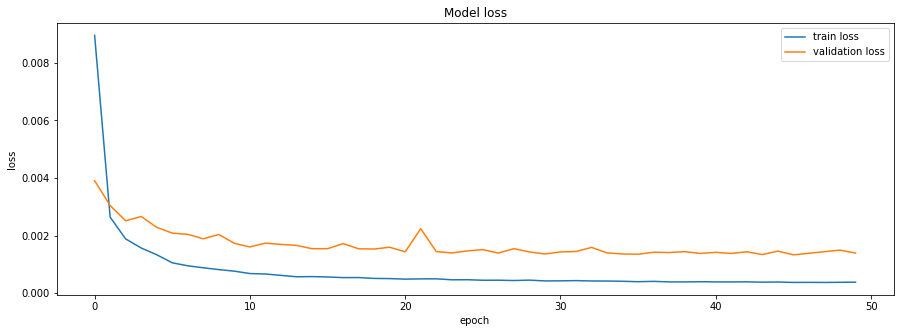

In [11]:
LOOKBACK=96
n=len(df)
train_df = df[:round(n*0.7)]
val_df = df[round(n*0.7):round(n*0.85)]
test_df = df[round(n*0.85):]

load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
train_load = load_scaler.fit_transform(np.array(train_df.load).reshape(-1, 1))
val_load = load_scaler.transform(np.array(val_df.load).reshape(-1, 1))
test_load = load_scaler.transform(np.array(test_df.load).reshape(-1, 1))
train_temp = temp_scaler.fit_transform(np.array(train_df.temperature).reshape(-1, 1))
val_temp = temp_scaler.transform(np.array(val_df.temperature).reshape(-1, 1))
test_temp = temp_scaler.transform(np.array(test_df.temperature).reshape(-1, 1))

print("\nTrain-size ->%d, Validation-size ->%d, Test-size->%d" % (len(train_df), len(val_df), len(test_df)))

train_X_load, train_X_temp, train_y = reframe(train_load, train_temp, LOOKBACK, HORIZON)
val_X_load, val_X_temp, val_y = reframe(val_load, val_temp, LOOKBACK, HORIZON)
test_X_load, test_X_temp, test_y = reframe(test_load, test_temp, LOOKBACK, HORIZON)

#print(train_X_load.shape, train_X_temp.shape, train_y.shape)

transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
train_X_temp = transformer.transform(train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1]))
val_X_temp = transformer.transform(val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1]))
test_X_temp = transformer.transform(test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1]))
#train_X_temp.shape, val_X_temp.shape, test_X_temp.shape

train_X_load = train_X_load.reshape(train_X_load.shape[0],train_X_load.shape[1],1)
train_X_temp = train_X_temp.reshape(train_X_temp.shape[0],train_X_temp.shape[1],train_X_temp.shape[2],1)
val_X_load = val_X_load.reshape(val_X_load.shape[0],val_X_load.shape[1],1)
val_X_temp = val_X_temp.reshape(val_X_temp.shape[0],val_X_temp.shape[1],val_X_temp.shape[2],1)
test_X_load = test_X_load.reshape(test_X_load.shape[0],test_X_load.shape[1],1)
test_X_temp = test_X_temp.reshape(test_X_temp.shape[0],test_X_temp.shape[1],test_X_temp.shape[2],1)
train_y = train_y.reshape(train_y.shape[0],train_y.shape[1])
val_y = val_y.reshape(val_y.shape[0],val_y.shape[1])
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1])
print("\nShape of Train_X_load, Train_X_temp and Train_y are\n", train_X_load.shape, train_X_temp.shape, train_y.shape)
print("\nShape of Val_X_load, Val_X_temp and Val_y are\n", val_X_load.shape, val_X_temp.shape, val_y.shape)
print("\nShape of Test_X_load, Test_X_temp and Test_y are\n", test_X_load.shape, test_X_temp.shape, test_y.shape)

load_inputs = layers.Input(shape=(LOOKBACK,1))
temp_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print("LOAD INPUTS ",load_inputs.shape)
x1 = layers.GRU(50, return_sequences=False)(load_inputs)
print(x1.shape)
x1 = layers.Dense(32, activation='relu')(x1)
print("LSTM OUT ",x1.shape)

print("TEMP INPUTS ",temp_inputs.shape)
x2 = layers.Convolution2D(filters=32, kernel_size=5, padding='valid')(temp_inputs)
x2 = layers.ReLU()(x2)
#x2 = layers.MaxPool2D()(x2)
print("CONVO BLOCK ",x2.shape)
x2 = layers.GlobalAvgPool2D()(x2)
print("Pool ",x2.shape)
x2 = layers.Dense(32,activation='relu')(x2)
print("CNN OUT ",x2.shape)

c1 = layers.Concatenate(axis=1)([x1,x2])
print("Concate ",c1.shape)
outputs = layers.Dense(1, activation='relu')(c1)
print("Output ",outputs.shape)

model = Model(inputs=[load_inputs, temp_inputs], outputs = outputs, name="PCNNGRU")
model.compile(optimizer='adam',loss='mse')

start_time = time.time()
hist = model.fit([train_X_load, train_X_temp], train_y, epochs=50, steps_per_epoch=steps(train_X_load.shape[0]),
  validation_steps=steps(val_X_load.shape[0]), validation_data=([val_X_load,val_X_temp],val_y),
  batch_size=BATCH_SIZE, verbose=1)
t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

pred_y = model.predict([test_X_load,test_X_temp])
pred = load_scaler.inverse_transform(pred_y)
actu = load_scaler.inverse_transform(test_y)
mae = metrics.mean_absolute_error(actu,pred)
mape = metrics.mean_absolute_percentage_error(actu,pred)*100
r2 = metrics.r2_score(actu,pred)
print("===> ",LOOKBACK)
print('\nEvaluation metric results:-\n')
print(f'MAE is : {mae}')
print(f'MAPE is : {mape}')
print(f'R2 is : {r2}')
print(f'Convergence time is : {t}')
print(' -------------------------',end='\n\n')
plot_history(hist)

In [12]:
print(pred.tolist())

[[65156.78515625], [62400.94921875], [62330.6875], [61987.765625], [58324.07421875], [53238.015625], [49591.6484375], [51981.63671875], [50114.52734375], [40161.30859375], [36368.25], [33255.7578125], [31428.158203125], [29862.638671875], [29049.28125], [27844.474609375], [27635.765625], [29049.1953125], [29024.517578125], [30184.60546875], [36005.02734375], [46202.14453125], [50987.4765625], [51812.015625], [51990.80859375], [50616.01171875], [48424.34375], [48615.6796875], [47942.4375], [47521.59375], [48722.91015625], [52264.71875], [51587.92578125], [40755.38671875], [37759.15625], [34487.34375], [32770.6328125], [31096.619140625], [29094.123046875], [28468.0859375], [27410.20703125], [28510.38671875], [29392.568359375], [29640.48046875], [29606.271484375], [37688.3046875], [45435.734375], [46141.84765625], [46277.8828125], [46272.1640625], [47010.8046875], [46438.97265625], [46005.2578125], [45932.49609375], [47046.2265625], [50641.24609375], [49773.9453125], [39703.06640625], [36

In [13]:
print(hist.history['loss'])

[0.008953518234193325, 0.002638890640810132, 0.001883549615740776, 0.001567428931593895, 0.001333325752057135, 0.0010532651795074344, 0.0009502823231741786, 0.0008802384836599231, 0.0008171467343345284, 0.0007636297377757728, 0.0006806117598898709, 0.0006651279982179403, 0.0006177645409479737, 0.0005689245299436152, 0.0005744881927967072, 0.0005614480469375849, 0.0005394527106545866, 0.0005413065082393587, 0.0005113391671329737, 0.0005052876658737659, 0.0004867916868533939, 0.0004952162853442132, 0.0004974840558134019, 0.00046376435784623027, 0.000466355326352641, 0.00044806537334807217, 0.0004494354361668229, 0.0004381145117804408, 0.00045246328227221966, 0.00042448073509149253, 0.00042710601701401174, 0.0004354334087111056, 0.0004227659374009818, 0.00042010529432445765, 0.00041232045623473823, 0.0003974750579800457, 0.0004091947339475155, 0.0003905366756953299, 0.0003904586483258754, 0.0003969328827224672, 0.00039046333404257894, 0.0003894629771821201, 0.0003928987425751984, 0.000381

In [14]:
print(hist.history['val_loss'])

[0.0039058781694620848, 0.0030423307325690985, 0.0025132352020591497, 0.0026618256233632565, 0.00228517665527761, 0.0020847513806074858, 0.0020424961112439632, 0.001887584337964654, 0.002037754748016596, 0.0017304527573287487, 0.0016056103631854057, 0.0017372140428051353, 0.0016930006677284837, 0.0016585555858910084, 0.0015441577415913343, 0.0015434367815032601, 0.001720343716442585, 0.0015409492189064622, 0.0015313432086259127, 0.0015945449704304338, 0.0014357853215187788, 0.0022395204287022352, 0.0014442327665165067, 0.001396539737470448, 0.0014657903229817748, 0.0015122435288503766, 0.0013919295743107796, 0.0015445101307705045, 0.001431652926839888, 0.0013608994195237756, 0.0014320032205432653, 0.001446048729121685, 0.0015883793821558356, 0.0013976308982819319, 0.0013596698408946395, 0.0013519041240215302, 0.0014200477162376046, 0.001410081167705357, 0.001442233333364129, 0.001379647059366107, 0.0014178549172356725, 0.0013787884963676333, 0.00143689033575356, 0.0013398535083979368, 